In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from xgboost import XGBClassifier
import json
from sklearn import metrics
from sklearn import utils
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
from catboost import metrics as catmet

In [2]:
class MLA(object):
    def __init__(self,traindatafile,testdatafile, trainnonpdatafile = None, testnonpdatafile = None, random_state = None):
        self.traindatafile = traindatafile
        self.trainnonpdatafile = trainnonpdatafile
        self.testdatafile = testdatafile
        self.testnonpdatafile = testnonpdatafile
        self.randomstate = random_state
        self.trainshuffle = False
        self.trainbalance = False
        self.testshuffle = False
        self.testbalance = False
    #self.datadict = None
    #self.LoadData()
    
    def LoadData(self, datatype):
        #Method that results in a single pulsar and non pulsar dictionary. 
        #First, check if loading in the training or testing dataset. Then sets it to the 
        #general data variable used in method.
        if datatype == 'train':
            datafile = self.traindatafile
            nonpdatafile = self.trainnonpdatafile
        elif datatype == 'test':
            datafile = self.testdatafile
            nonpdatafile = self.testnonpdatafile
            
        #First, loading a single p/nonp dataset.
        if nonpdatafile is None:
            totaldatadict = np.load(datafile,allow_pickle=True)
            if isinstance(totaldatadict, dict): #directly sets the train/test attribute if data already formatted
                if datatype == 'train':
                    self.traindatadict = totaldatadict
                elif datatype == 'test':
                    self.testdatadict = totaldatadict
            else: #else converts to dictionary then sets the attributes.
                if datatype == 'train':
                    self.traindatadict = totaldatadict[()]
                elif datatype == 'test':
                    self.testdatadict = totaldatadict[()] 
        
        #Second, loading data if pulsar and non pulsar data is separate
        if nonpdatafile is not None:
            #loading in the arrays and unpacking the dictionaries
            pulsardata = np.load(datafile,allow_pickle=True)
            pulsardatadict = pulsardata[()]
            #print(pulsardatadict)
            nonpulsardata = np.load(nonpdatafile,allow_pickle=True)
            nonpulsardatadict = nonpulsardata[()]
        
            #looping over the array keys
            totaldatadict = {}
        
            for key in pulsardatadict.keys():
                #print(key)
                if len(np.shape(pulsardatadict[key])) == 1:
                    totaldatadict[key] = np.append(pulsardatadict[key],nonpulsardatadict[key])
                    #print(np.shape("pulsardatashape:",pulsardatadict[key]))
                    #print(np.shape("nonpulsardatashape:",nonpulsardatadict[key]))
                else:
                    totaldatadict[key] = []
                    for item in pulsardatadict[key]:
                     #   print(item)
                        totaldatadict[key].append(item)
                    for item in nonpulsardatadict[key]:
                      #  print(item)
                        totaldatadict[key].append(item)
                    #totaldatadict[key] = np.append(pulsardatadict[key],nonpulsardatadict[key],axis=1)
                
            if datatype == 'train':
                self.traindatadict = totaldatadict
            elif datatype == 'test':
                self.testdatadict = totaldatadict


    def ShuffleData(self,datatype, randomstate):
        if datatype == 'train':
            datadict = self.traindatadict 
        elif datatype == 'test':
            datadict = self.testdatadict
        #if self.randomstate is None:
         #   self.randomstate = #random gen
            
       
        print(datadict.keys())
        for key in datadict.keys():
            #shuffledict[key] = utils.shuffle(datadict[key],random_state = self.randomstate)
            print(datadict[key][1])
            np.random.seed(randomstate)
            np.random.shuffle(datadict[key])
            print(datadict[key][1])
        if datatype == 'train':
            self.traindatadict = datadict
            self.trainshuffle = True
        elif datatype == 'test':
            self.testdatadict = datadict
            self.testshuffle = True
        
        
    def DataBalanceCheck(self, datatype):
        if datatype == 'train':
            totaldatadict = self.traindatadict 
        elif datatype == 'test':
            totaldatadict = self.testdatadict
        
        for key in totaldatadict.keys():
            print(key)
        posvalues = 0
        negvalues = 0
        for i in range(len(totaldatadict['Train Labels'])):
            if totaldatadict['Train Labels'][i] == 1.0:
                posvalues = posvalues + 1.0
            elif totaldatadict['Train Labels'][i] == 0.0:
                negvalues = negvalues +1.0
        pospercent = (posvalues/len(totaldatadict['Train Labels']))*100
        negpercent = (negvalues/len(totaldatadict['Train Labels']))*100
        #posvalues = np.sum(totaldatadict['Train Labels'])
        #negvalues = len(totaldatadict['Train Labels']) - posvalues
        self.pos = posvalues
        self.neg = negvalues
        self.pospercent = pospercent
        self.negpercent = negpercent
        self.datamix = "Data set is {}% pulsar and {}% nonpulsar.".format(pospercent, negpercent)
        
    
    def BalanceData(self, datatype):
        if datatype == 'train':
            totaldatadict = self.traindatadict 
        elif datatype == 'test':
            totaldatadict = self.testdatadict
            
        self.DataBalanceCheck(datatype)
        poscount = self.pos
        negcount = self.neg
        print("poscount is ", poscount)
        print("negcount is ", negcount)
        print(negcount+poscount)
        baldatadict = {}
        labelsarray = []
        profarray = []
        keylist = []
        if negcount > poscount: 
            negkeep = 0 #initializing the number of entries that have been deleted
            for i in range(int(poscount+poscount)): #indexing over entire length becuase I don't know how the data is shuffled
              
                labelsarray.append(totaldatadict['Train Labels'][i])
                profarray.append(totaldatadict['Sum Prof'][i])
            print("Labelsarray:",len(labelsarray))
            baldatadict['Train Labels'] = labelsarray
            print(len(baldatadict['Train Labels']))
            self.ncount = len(baldatadict['Train Labels'])
            print("Profarray:",len(profarray))
            baldatadict['Sum Prof'] = profarray  
            print(len(baldatadict['Sum Prof']))
        elif negcount == poscount:
            baldatadict = totaldatadict
        if datatype == 'train':
            self.traindatadict = baldatadict
            self.trainbalance = True
        elif datatype == 'test':
            print("test")
            self.testdatadict = baldatadict
            self.testbalance = True
        
        #self.SaveBalancedData(datatype)
          
               # if negkeep == (poscount): #once number of deletions = pos/neg discrepancy, stop the loop
                #    break
                #if datadict['Train Labels'][i] == 1: #if the entry is a pulsar, go to next entry
                 #   pass
                #if datadict['Train Labels'][i] == 0: #if the entry is a nonpulsar, pass but add to neg counter
                 #   for key in datadict.keys():
                  #      np.delete(datadict[key],i,0) #numpy.delete(array, index, axis)
                   # negkeep = negkeep + 1
                    #print(negkeep)

                
                
                
             #   for item in keylist:
              #      baldatadict[key] = []
               #     baldatadict[key].append(totaldatadict[key][i])
            
    
        
    def SaveData(self,datatype):
        if datatype == 'train':
            np.save("TrainSet.npy", self.traindatadict)
        elif datatype == 'test':
            np.save("TestSet.npy", self.testdatadict)
        #just save as dict, in init add user specified file name
        
    def ROC_Curve(self, labels):
      #takes in predictions bc there will be too many to be an attribute
        falsepos, truepos, thresholds = metrics.roc_curve(labels, self.predictions)
        display = metrics.RocCurveDisplay(fpr=falsepos, tpr=truepos)
        auc = metrics.auc(falsepos, truepos)
        print("AUC Score:", auc)
        display.plot()
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],"r--")
      


In [3]:
test = MLA('PULSAR_TRAIN.npy','PULSAR_TEST.npy','NONP_TRAIN.npy','NONP_TEST.npy')

In [5]:
test.LoadData('test')

In [6]:
test.DataBalanceCheck('test')

Subband
DM Plots
Persistence
Sum Prof
Train Labels
RA
DEC
p1
p2
p3
Best DM
Chi2
Max DM


In [8]:
class CNN(MLA):
    def ModelFeatures(self):
        pass
    def BalanceData(self, datatype):
        if datatype == 'train':
            totaldatadict = self.traindatadict 
        elif datatype == 'test':
            totaldatadict = self.testdatadict
        
        self.DataBalanceCheck(datatype)
        poscount = self.pos
        negcount = self.neg
        print("poscount is ", poscount)
        print("negcount is ", negcount)
        print(negcount+poscount)
        baldatadict = {}
        labelsarray = []
        subplotarray = []
        persplotarray =[]
        dmplotarray = []
        if negcount > poscount: 
            for i in range(int(poscount+poscount)): #indexing over entire length becuase I don't know how the data is shuffled
                labelsarray.append(totaldatadict['Train Labels'][i])
                subplotarray.append(totaldatadict['Subband'][i])
                persplotarray.append(totaldatadict['Persistence'][i])
                dmplotarray.append(totaldatadict['DM Plots'][i])
            print("Labelsarray:",len(labelsarray))
            baldatadict['Train Labels'] = labelsarray
            print(len(baldatadict['Train Labels']))
            self.ncount = len(baldatadict['Train Labels'])
            print("Subplot array:",len(subplotarray))
            baldatadict['Subband'] = subplotarray  
            print(len(baldatadict['Subband']))
            print("Persistenceplot array:",len(persplotarray))
            baldatadict['Persistence'] = persplotarray  
            print(len(baldatadict['Persistence']))
            print("DMplot array:",len(dmplotarray))
            baldatadict['DM Plots'] = dmplotarray  
            print(len(baldatadict['DM Plots']))
        elif negcount == poscount:
            baldatadict['Train Labels'] = totaldatadict['Train Labels']
            baldatadict['Subband'] = totaldatadict['Subband']
            baldatadict['Persistence'] =totaldatadict['Persistence']
            baldatadict['DM Plots'] =totaldatadict['DM Plots']
        if datatype == 'train':
            self.traindatadict = baldatadict
            self.trainbalance = True
        elif datatype == 'test':
            print("test")
            self.testdatadict = baldatadict
            self.testbalance = True
            
    def SaveData(self,datatype):
        if datatype == 'train':
            np.save("CNNTrainSet.npy", self.traindatadict)
        elif datatype == 'test':
            np.save("CNNTestSet.npy", self.testdatadict)
        #just save as dict, in init add user specified file name
    
    def FlattenData(self, datatype): #for the two 1D CNNs
        if datatype == 'train':
            datadict = self.traindatadict 
        elif datatype == 'test':
            datadict = self.testdatadict
        
        persdata_array = np.array(datadict['Persistence']) #converting the DM data into an array (no need for labels)
        persdatalength = len(persdata_array) #creates a variable with the number of candidates in the dataset
        persdata_flat = persdata_array.reshape(persdatalength,-1) # flattens the features of the data set into one axis 
        
        dmdata_array = np.array(datadict['DM Plots'])
        dmdatalength = len(dmdata_array)
        dmdata_flat = dmdata_array.reshape(dmdatalength,-1)
        
        if datatype == 'train':
            self.trainpersdata = persdata_flat
            self.trainperslabels = datadict['Train Labels']
            
            self.traindmdata = dmdata_flat
            self.traindmlabels = datadict['Train Labels']
            
        elif datatype == 'test':
            self.testpers1ddata = persdata_flat
            self.testpers1dlabels = datadict['Train Labels']
            
            self.testdm1ddata = dmdata_flat
            self.testdm1dlabels = datadict['Train Labels']
            
    def DataPrep(self, datatype, plot):
        if datatype == 'train':
            datadict = self.traindatadict
            self.trainsubdata = datadict['Subband']
            self.trainsublabels = datadict['Train Labels']
            self.train2dpersdata = datadict['Persistence']
            self.train2dperslabels = datadict['Train Labels']
            
            persdata_array = np.array(datadict['Persistence']) #converting the DM data into an array (no need for labels)
            persdatalength = len(persdata_array) #creates a variable with the number of candidates in the dataset
            self.train1dpersdata = persdata_array.reshape(persdatalength,-1) # flattens the features of the data set into one axis 
        
            dmdata_array = np.array(datadict['DM Plots'])
            dmdatalength = len(dmdata_array)
            dmdata_flat = dmdata_array.reshape(dmdatalength,-1)
        elif datatype == 'test':
            datadict = self.testdatadict
            self.testsubdata = datadict['Subband']
            self.testsublables = datadict['Train Labels']
            self.test2dpersdata = datadict['Persistence']       
            self.test2dperslabels = datadict['Train Labels']
            self.testdmdata = datadict['DM Plots']        
            self.testdmlabels = datadict['Train Labels']
                
    def Build1DModel(self,plot):
        model = models.Sequential([layers.Conv1D(64, 6, activation='relu', input_shape = (120,1)), 
            layers.MaxPooling1D(2), 
            layers.Conv1D(32, 3, activation='relu'), 
            layers.MaxPooling1D(1),
            layers.Flatten(),
            layers.Dense(10, activation='relu'),
            layers.Dense(1, activation='sigmoid')]) #output layer, 1 node 
        
        if plot == 'Persistence':
            self.pers1dmodel = model
        if plot == 'DM Plots':
            self.dm1dmodel = model
    def Build2DModel(self,plot):
        if plot == 'Subband':
            inputshape = (128,200,1)
        if plot == 'Peristence':
            inputshape=(200, 50, 1)
            
        model2d = models.Sequential([layers.Conv2D(32, (3, 3), activation='relu', input_shape=inputshape), #layer with 112 nodes
            layers.MaxPooling2D((2, 2)), #layer with 112 nodes
            layers.Flatten(),
            layers.Dense(10, activation='relu'),
            layers.Dense(1, activation='sigmoid')]) #output layer, 1 node 
        
        if plot == 'Subband':
            self.plot = 'Subband'
            self.submodel = model2d
        if plot == 'Persistence':
            self.plot = 'Persistence'
            self.pers2dmodel = model2d
    
    def TrainModel(self, persdim = None):
        if self.plot == 'Subband':
            model = self.submodel
            train = self.trainsubdata
            trainlabels = self.trainsublabels
        if self.plot == 'Persistence':
            if persdim = 1:
                model = self.pers1dmodel
            if persdim = 2:
                model = self.pers2dmodel
        if self.plot == 'DM Plots':
            model = self.dm1dmodel
            train = self.traindmdata
            trainlabels = self.traindmlabels
            
        model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])
        
        history = model.fit((train, trainlabels, epochs=10, 
                    validation_split = 0.2, batch_size = 1))
        if self.plot == 'Subband':
            self.historysubmodel = history
        if self.plot == 'Persistence':
            if persdim = 1:
                self.history1dmodel = history
            if persdim = 2:
                self.history2dmodel = history    
        if self.plot == 'DM Plots':
            self.historydmmodel = history
            
    def LoadModel(self, plot, persdim = None, modelpath):
        model = keras.models.load_model(modelpath)
        if plot == 'Subband':
            self.submodel = model
        if plot == 'Peristence':
            if persdim = 1:
                self.pers1dmodel = model
            if persdim = 2:
                self.pers2dmodel = model
        if plot == 'DM Plots':
            self.dmmodel = model
    def TestModel(self):
        if self.plot == 'Subband':
            model = self.submodel
            test = self.testsubdata
        if self.plot == 'Persistence':
            if persdim = 1:
                model = self.pers1dmodel
                test = self.test1dpersdata
            if persdim = 2:
                model = self.pers2dmodel
                test = self.test2dpersdata
        if self.plot == 'DM Plots':
            model = self.dm1dmodel
            test = self.testdmdata
            
        predictions = model.predict(test)
        
        if self.plot == 'Subband':
            self.predictionssubmodel = predictions
        if self.plot == 'Persistence':
            if persdim = 1:
                self.predictionspers1dmodel = predictions
            if persdim = 2:
                self.predictionspers2dmodel = predictions    
        if self.plot == 'DM Plots':
            self.predictionsdm1dmodel = predictions
    
    def SaveModel(self, plot, persdim = None, modelpath):
        if self.plot == 'Subband':
            model = self.submodel
        if self.plot == 'Persistence':
            if persdim = 1:
                model = self.pers1dmodel
            if persdim = 2:
                model = self.pers2dmodel
        if self.plot == 'DM Plots':
            model = self.dm1dmodel
        
        model.save(path) 
        
    
    
        
          
                

In [9]:
cnn = CNN('PULSAR_TRAIN.npy','PULSAR_TEST.npy','NONP_TRAIN.npy','NONP_TEST.npy')

In [10]:
cnn.LoadData('test')
cnn.LoadData('train')

In [11]:
cnn.BalanceData('test')
cnn.BalanceData('train')

Subband
DM Plots
Persistence
Sum Prof
Train Labels
RA
DEC
p1
p2
p3
Best DM
Chi2
Max DM
poscount is  1000.0
negcount is  1000.0
2000.0
test
Subband
DM Plots
Persistence
Sum Prof
Train Labels
RA
DEC
p1
p2
p3
Best DM
Chi2
Max DM
poscount is  3222.0
negcount is  51150.0
54372.0
Labelsarray: 6444
6444
Subplot array: 6444
6444
Persistenceplot array: 6444
6444
DMplot array: 6444
6444


In [13]:
cnn.ShuffleData('test',14)
cnn.ShuffleData('train',14)

dict_keys(['Train Labels', 'Subband', 'Persistence', 'DM Plots'])
1.0
0.0
[[0.00068135 0.0004916  0.00060607 ... 0.00088455 0.00011342 0.00122504]
 [0.00046548 0.00063879 0.00081677 ... 0.00118916 0.00108606 0.00094473]
 [0.00069112 0.00134504 0.0012006  ... 0.00103387 0.00071807 0.00064985]
 ...
 [0.00025944 0.0002023  0.00043572 ... 0.00051975 0.00027316 0.00027574]
 [0.00036885 0.00030829 0.00010472 ... 0.00035913 0.00040947 0.00033855]
 [0.         0.00033833 0.00033908 ... 0.00023769 0.00013872 0.00021636]]
[[2.03766254e-04 1.92547703e-04 1.81329153e-04 ... 8.74199729e-05
  7.76793528e-05 6.79387328e-05]
 [2.00644465e-04 1.89765119e-04 1.78885773e-04 ... 8.90018163e-05
  7.95383153e-05 7.00748144e-05]
 [2.94690218e-04 3.25068873e-04 3.55447528e-04 ... 7.67895809e-04
  7.94694813e-04 8.21493817e-04]
 ...
 [3.07732546e-05 2.95608300e-05 2.83484054e-05 ... 2.18685398e-05
  2.81358440e-05 3.44031482e-05]
 [1.28740370e-05 1.96486965e-05 2.64233561e-05 ... 1.92897503e-05
  1.99213255e-0

In [14]:
cnn.SaveData('test')
cnn.SaveData('train')

In [73]:
class CatBoost(MLA):
    def ModelFeatures(self):
        pass
    def BalanceData(self, datatype):
        if datatype == 'train':
            totaldatadict = self.traindatadict 
        elif datatype == 'test':
            totaldatadict = self.testdatadict
        
        self.DataBalanceCheck(datatype)
        poscount = self.pos
        negcount = self.neg
        print("poscount is ", poscount)
        print("negcount is ", negcount)
        print(negcount+poscount)
        baldatadict = {}
        labelsarray = []
        subplotarray = []
        pplotarray =[]
        if negcount > poscount: 
            for i in range(int(poscount+poscount)): #indexing over entire length becuase I don't know how the data is shuffled
                labelsarray.append(totaldatadict['Train Labels'][i])
                subplotarray.append(totaldatadict['Subband'][i])
                pplotarray.append(totaldatadict['Sum Prof'][i])
            print("Labelsarray:",len(labelsarray))
            baldatadict['Train Labels'] = labelsarray
            print(len(baldatadict['Train Labels']))
            self.ncount = len(baldatadict['Train Labels'])
            print("Subplot array:",len(subplotarray))
            baldatadict['Subband'] = subplotarray  
            print(len(baldatadict['Subband']))
            print("Pulseplot array:",len(pplotarray))
            baldatadict['Sum Prof'] = pplotarray  
            print(len(baldatadict['Sum Prof']))
        elif negcount == poscount:
            baldatadict['Train Labels'] = totaldatadict['Train Labels']
            baldatadict['Subband'] = totaldatadict['Subband']
            baldatadict['Sum Prof'] =totaldatadict['Sum Prof']
        if datatype == 'train':
            self.traindatadict = baldatadict
            self.trainbalance = True
        elif datatype == 'test':
            print("test")
            self.testdatadict = baldatadict
            self.testbalance = True
            
    def SaveData(self,datatype):
        if datatype == 'train':
            np.save("CatTrainSet.npy", self.traindatadict)
        elif datatype == 'test':
            np.save("CatTestSet.npy", self.testdatadict)
        #just save as dict, in init add user specified file name
            
    def FlattenData(self, datatype):
        if datatype == 'train':
            subdatadict = self.traindatadict 
        elif datatype == 'test':
            subdatadict = self.testdatadict
        
        subdata_array = np.array(subdatadict['Subband']) #converting the DM data into an array (no need for labels)
        datalength = len(subdata_array) #creates a variable with the number of candidates in the dataset
        subdata_flat = subdata_array.reshape(datalength,-1) # flattens the features of the data set into one axis 
        
        
        if datatype == 'train':
            self.trainsubdata = subdata_flat
            self.trainsublabels = subdatadict['Train Labels']
            
        elif datatype == 'test':
            self.testsubdata = subdata_flat
            self.testsublabels = subdatadict['Train Labels']
    
    def ValidationSplit(self, val_split = 0.2, randomstate = 1):
        #Splitting Subband data
        subdata = self.trainsubdata
        sublabels = self.trainsublabels
        trainsubdata, valsubdata, trainsublabels, valsublabels = train_test_split(subdata, sublabels, test_size= val_split, random_state=randomstate)
        self.trainsubdata = trainsubdata
        self.trainsublabels = trainsublabels
        self.valsubdata = valsubdata
        self.valsublabels = valsublabels
        
        #Splitting Pulse Profile data
        traindata = self.traindatadict
        pulsedata = traindata['Sum Prof']
        pulselabels = traindata['Train Labels']
        trainpulsedata, valpulsedata, trainpulselabels, valpulselabels = train_test_split(pulsedata, pulselabels, test_size= val_split, random_state=randomstate)
        self.trainpulsedata = trainpulsedata
        self.trainpulselabels = trainpulselabels
        self.valpulsedata = valpulsedata
        self.valpulselabels = valpulselabels
        #Just assigning pulse test attribute, since this is done for subband only in the flatten method
        testdata = self.testdatadict
        self.testpulsedata = testdata['Sum Prof']
        self.testpulselabels = testdata['Train Labels']
        
    def BuildModel(self, plot, randomseed = 1):
        model = CatBoostClassifier(
                custom_loss=[catmet.Accuracy()],
                random_seed=randomseed,
                logging_level='Silent')
        
        if plot == 'Subband':
            self.plot = 'Subband'
            self.submodel = model
        if plot == 'Sum Prof':
            self.plot = 'Sum Prof'
            self.pulsemodel = model
            
    def TrainModel(self,plotting = True): #plotting is whether or not catboost prints the dynamic graph
        if self.plot == 'Subband':
            traindata = self.testsubdata #don't need to pull out data dict bc subdata attribute assigned when flattened
            valdata = self.valsubdata
            trainlabels = self.testsublabels
            vallabels = self.valsublabels
            model = self.submodel
        if self.plot == 'Sum Prof':
            traindata = self.trainpulsedata
            valdata = self.valpulsedata
            trainlabels = self.trainpulselabels
            vallabels = self.valpulselabels
            model = self.pulsemodel
            
        model.fit(traindata, trainlabels,
                #cat_features=categorical_features_indices,
                eval_set=(valdata, vallabels),
                #logging_level='Verbose',  # you can uncomment this for text output
                plot=plotting);
        if self.plot == 'Subband':
            self.submodel = model
        if self.plot == 'Sum Prof':
            self.pulsemodel = model
            
    def CrossValidateModel(self):
        pass
    
    def LoadModel(self, plot, filename):
        model = CatBoostClassifier()
        model.load_model(filename)
        
        if plot == 'Subband':
            self.submodel = model
            self.plot = 'Subband'
        if plot == 'Sum Prof':
            self.pulsemodel = model
            self.plot = 'Sum Prof'
        
    def TestModel(self):
        if self.plot == 'Subband':
            model = self.submodel
            testdata = self.testsubdata
        if self.plot == 'Sum Prof':
            model = self.pulsemodel
            testdata = self.testpulsedata
        
        predictions = model.predict(testdata)
        predictions_probs = model.predict_proba(testdata)
        posprobs = []
        for i in range(len(predictions_probs)):
            posprobs.append(predictions_probs[i][1])
        #I'm not making these attributes plot specific because the ROC_Curve function just uses self.predictions
        self.predictions_binary = predictions
        self.predictions = posprobs
    
    def SaveModel(self, plot, modelname):
        if plot == 'Subband':
            model = self.submodel
            model.save_model(modelname)
        if plot == 'Sum Prof':
            model = self.pulsemodel
            model.save_model(modelname)

        

In [74]:
cat = CatBoost('PULSAR_TRAIN.npy','PULSAR_TEST.npy','NONP_TRAIN.npy','NONP_TEST.npy')

In [75]:
cat.LoadData('train')
cat.LoadData('test')

In [76]:
cat.BalanceData('train')
cat.BalanceData('test')

poscount is  3222.0
negcount is  51150.0
54372.0
Labelsarray: 6444
6444
Subplot array: 6444
6444
Pulseplot array: 6444
6444
poscount is  1000.0
negcount is  1000.0
2000.0
test


In [77]:
cat.ShuffleData('train',5)
cat.ShuffleData('test',5)

dict_keys(['Train Labels', 'Subband', 'Sum Prof'])
1.0
0.0
[[5.10578653e-04 3.36462392e-04 1.62346132e-04 ... 3.01624880e-04
  3.94683306e-04 4.87741732e-04]
 [5.09548342e-04 3.35522833e-04 1.61497325e-04 ... 3.01752871e-04
  3.94004555e-04 4.86256238e-04]
 [7.21726159e-04 5.60995385e-04 4.00264611e-04 ... 6.61004789e-04
  6.53004522e-04 6.45004254e-04]
 ...
 [6.27990024e-05 5.68678338e-05 5.09366652e-05 ... 2.49301980e-05
  3.54967141e-05 4.60632302e-05]
 [9.95676309e-06 1.07915888e-05 1.16264144e-05 ... 9.80352059e-06
  9.85787258e-06 9.91222458e-06]
 [9.24460511e-05 8.70431081e-05 8.16401650e-05 ... 4.07958402e-05
  4.70986913e-05 5.34015423e-05]]
[[1.61007430e-04 1.55356532e-04 1.49705634e-04 ... 1.61361872e-04
  1.68240966e-04 1.75120059e-04]
 [1.59419531e-04 1.53859848e-04 1.48300165e-04 ... 1.60069566e-04
  1.66852131e-04 1.73634696e-04]
 [4.68911825e-05 5.29397405e-05 5.89882985e-05 ... 8.38034948e-05
  7.84206256e-05 7.30377565e-05]
 ...
 [2.00778636e-06 2.30539759e-06 2.60300

In [78]:
cat.FlattenData('train')
cat.FlattenData('test')

In [79]:
cat.ValidationSplit(val_split = 0.21, randomstate = 5)

In [80]:
cat.BuildModel('Sum Prof', randomseed = 4)

In [81]:
len(cat.trainpulselabels)

5090

In [82]:
len(cat.trainpulsedata)

5090

In [83]:
cat.TrainModel()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [84]:
cat.TestModel()

In [38]:
cat.predictions = np.array(cat.predictions)

In [44]:
falsepos, truepos, thresholds = metrics.roc_curve(cat.testsublabels, np.array(cat.predictions))

In [59]:
i = 9
print(cat.testsublabels[i])
print(cat.predictions[i])

0.0
0.0037999155233460367


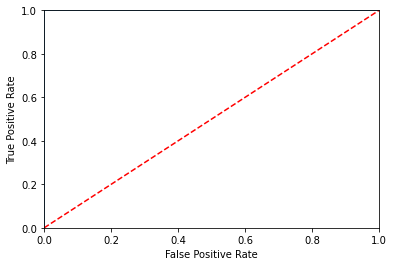

In [47]:
display = metrics.RocCurveDisplay(fpr=falsepos, tpr=truepos)
display.plot()
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],"r--")

In [48]:
print(display)

AUC Score: 0.963102


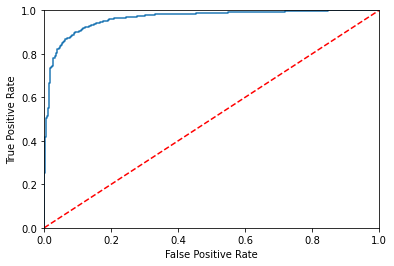

In [85]:
cat.ROC_Curve(cat.testpulselabels)

In [37]:
cat.testsublabels()

TypeError: 'numpy.ndarray' object is not callable

In [9]:
cat.SaveData('train')
cat.SaveData('test')

In [29]:
class XGBoost(MLA):
    def ModelFeatures(self):
        pass
    def BalanceData(self, datatype):
        if datatype == 'train':
            totaldatadict = self.traindatadict 
        elif datatype == 'test':
            totaldatadict = self.testdatadict
            
        self.DataBalanceCheck(datatype)
        poscount = self.pos
        negcount = self.neg
        print("poscount is ", poscount)
        print("negcount is ", negcount)
        print(negcount+poscount)
        baldatadict = {}
        labelsarray = []
        dmplotarray = []
        if negcount > poscount: 
            for i in range(int(poscount+poscount)): #indexing over entire length becuase I don't know how the data is shuffled
                labelsarray.append(totaldatadict['Train Labels'][i])
                dmplotarray.append(totaldatadict['DM Plots'][i])
            print("Labelsarray:",len(labelsarray))
            baldatadict['Train Labels'] = labelsarray
            print(len(baldatadict['Train Labels']))
            self.ncount = len(baldatadict['Train Labels'])
            print("DMplot array:",len(dmplotarray))
            baldatadict['DM Plots'] = dmplotarray  
            print(len(baldatadict['DM Plots']))
        elif negcount == poscount:
            baldatadict['Train Labels'] = totaldatadict['Train Labels']
            baldatadict['DM Plots'] = totaldatadict['DM Plots']
        if datatype == 'train':
            self.traindatadict = baldatadict
            self.trainbalance = True
        elif datatype == 'test':
            print("test")
            self.testdatadict = baldatadict
            self.testbalance = True
        
        #self.SaveBalancedData(datatype)
        
    def FlattenData(self, datatype):
        if datatype == 'train':
            dmdatadict = self.traindatadict 
        elif datatype == 'test':
            dmdatadict = self.testdatadict
        
        dmdata_array = np.array(dmdatadict['DM Plots']) #converting the DM data into an array (no need for labels)
        datalength = len(dmdata_array) #creates a variable with the number of candidates in the dataset
        dmdata_flat = dmdata_array.reshape(datalength,-1) # flattens the features of the data set into one axis 
        
        
        if datatype == 'train':
            self.traindmdata = dmdata_flat
            self.traindmlabels = dmdatadict['Train Labels']
            
        elif datatype == 'test':
            self.testdmdata = dmdata_flat
            self.testdmlabels = dmdatadict['Train Labels']
            
    def BuildModel(self):
        self.xgbmodel = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=0.001, objective='binary:logistic')
        
    def TrainModel(self):
        model = self.xgbmodel
        model.fit(self.traindmdata,self.traindmlabels)
        self.xgbmodel = model
        
    def TestModel(self):
        model = self.xgbmodel
        probability = model.predict_proba(self.testdmdata)
        pulsarprobability = []
        for i in range(len(probability)):
            pulsarprobability.append(probability[i][1])
        self.predictions = pulsarprobability
        self.ROC_Curve(self.testdmlabels)
    
    def SaveModel(self):
        
        

In [30]:
boost = XGBoost('PULSAR_TRAIN.npy','PULSAR_TEST.npy','NONP_TRAIN.npy','NONP_TEST.npy')

In [31]:
boost.LoadData('train')

In [32]:
boost.LoadData('test')

In [33]:
boost.BalanceData('train')


poscount is  3222.0
negcount is  51150.0
54372.0
Labelsarray: 6444
6444
DMplot array: 6444
6444


In [34]:
boost.BalanceData('test')

poscount is  1000.0
negcount is  1000.0
2000.0
test


In [35]:
boost.ShuffleData('train',8)
boost.ShuffleData('test',8)

dict_keys(['Train Labels', 'DM Plots'])
1.0
1.0
[[  1.47483778   1.55486465   1.49284947   1.449157     1.46048188
    1.46560502   1.43936408   1.53183568   1.6310935    1.78675151
    2.01124525   2.2883389    2.46437693   2.57245135   2.8063364
    3.08321476   3.45590687   3.66940355   3.85441828   4.27692223
    4.69639778   5.14864635   5.74140692   6.30075359   6.82673883
    7.43893003   7.82995224   8.15165806   8.42415237   8.37517548
    8.24226856   7.88922119   7.44693756   6.92634106   6.46442413
    6.14273024   5.78374481   5.21554279   4.56855917   4.11787462
    3.59580827   3.12917399   2.85121036   2.69067907   2.51327395
    2.34048462   2.21595168   2.1164391    1.97881448   1.7981571
    1.65468585   1.61644399   1.75062478   1.73810911   1.62213159
    1.6044383    1.58105016   1.51150393   1.43816316   1.34720421]
 [135.29953232 135.39954817 135.49956403 135.59957988 135.69959573
  135.79961159 135.89962744 135.99964329 136.09965915 136.199675
  136.29969085 13

In [36]:
boost.SaveData('train')
boost.SaveData('test')

In [37]:
data = boost.traindatadict
for key in data.keys():
    print(key)

Train Labels
DM Plots


In [38]:
boost.FlattenData('train')
boost.FlattenData('test')

In [39]:
boost.BuildModel()

In [40]:
boost.TrainModel()

AUC Score: 0.704


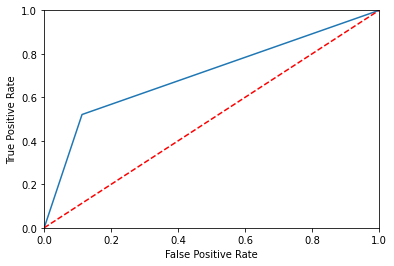

In [41]:
boost.TestModel()

In [3]:
class PulseProfileANN(MLA):
    def ModelFeatures(self, epoch = 200,validation_split=0.2, run_name = "pp_ANN"):
        self.epoch = epoch
        self.valsplit = validation_split
        self.name = run_name
  
    def PullData(self):
        traindatadict = self.traindatadict
        print("train")
        for key in traindatadict.keys():
            print(key)
        self.trainPPdata = traindatadict['Sum Prof']
        self.trainPPlabels = traindatadict['Train Labels']
        self.trainPPdata = np.array(self.trainPPdata)
        self.trainPPlabels = np.array(self.trainPPlabels)
        #self.trainPPdata = self.trainPPdata.T
        print("ncount = ", self.ncount)
        #self.trainPPdata = tf.convert_to_tensor(self.trainPPdata)
        print("train:",np.shape(self.trainPPdata))
        
        testdatadict = self.testdatadict
        print("test")
        for key in testdatadict.keys():
            print(key)
        self.testPPdata = testdatadict['Sum Prof']
        self.testPPlabels = testdatadict['Train Labels']
        self.testPPdata = np.array(self.testPPdata)
        self.testPPlabels = np.array(self.testPPlabels)
        #self.testPPdata = self.testPPdata.T
        #self.testPPdata = tf.convert_to_tensor(self.testPPdata)
        print("test:",np.shape(self.testPPdata))
        
            
    def BuildModel(self):
    
        #self.checkpoint_path = self.name + ".ckpt"
        #checkpoint_dir = os.path.dirname(self.checkpoint_path)
    
        #callback saves weights every epoch
        self.callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='pp_ANN.ckpt',
            verbose=1,
            save_weights_only=True,
            save_freq=self.epoch)
    
        self.early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

        pp_ANN = keras.Sequential([ 
            keras.layers.Dense(112, activation='sigmoid', input_dim = 200), #layer with 112 nodes
            keras.layers.Dense(112, activation='sigmoid'), #layer with 112 nodes
            keras.layers.Dense(1, activation='sigmoid') #output layer, 1 node
        ])
        pp_ANN.summary()
        self.model = pp_ANN
        
    
    def TrainModel(self):
        pp_ANN = self.model
        pp_ANN.compile(optimizer='nadam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        print(np.shape(self.trainPPdata))
        print(np.shape(self.trainPPlabels))
        print("data type is ", type(self.trainPPdata))
        print("label type is ", type(self.trainPPlabels))
        
        print(self.trainPPlabels[0])
        print(self.trainPPdata[0])
        
        history = pp_ANN.fit(self.trainPPdata, self.trainPPlabels, epochs = self.epoch,validation_split = self.valsplit, verbose = 1, callbacks=[self.early_stop, self.callback])
        #
        #model.save_weights(checkpoint_path.format(epoch=0))
        pp_ANN.summary()
        self.model = pp_ANN

    #evaluate func for loss
    #pp_test_loss, pp_test_acc = model.evaluate(pp_test,  test_labels, verbose=2)
    
    def LoadModel(self, modelpath):
        self.model = keras.models.load_model(modelpath)
    
    def TestModel(self):
        pp_ANN = self.model
        #testdata = tf.convert_to_tensor(self.testPPdata)
        predictions = pp_ANN.predict(self.testPPdata)
        self.predictions = predictions

        #self.ROC_curve(predictions)
        
    def SaveModel(self, path):
        pp_ANN = self.model
        pp_ANN.save(path)

In [4]:
test = PulseProfileANN('PULSAR_TRAIN.npy','PULSAR_TEST.npy','NONP_TRAIN.npy','NONP_TEST.npy')

In [5]:
test.LoadData('train')

In [6]:
test.DataBalanceCheck('train')

Subband
DM Plots
Persistence
Sum Prof
Train Labels
RA
DEC
p1
p2
p3
Best DM
Chi2
Max DM


In [7]:
test.BalanceData('train')

Subband
DM Plots
Persistence
Sum Prof
Train Labels
RA
DEC
p1
p2
p3
Best DM
Chi2
Max DM
poscount is  3222.0
negcount is  51150.0
54372.0
Labelsarray: 6444
6444
Profarray: 6444
6444


In [8]:
test.LoadData('test')

In [9]:
test.BalanceData('test')

Subband
DM Plots
Persistence
Sum Prof
Train Labels
RA
DEC
p1
p2
p3
Best DM
Chi2
Max DM
poscount is  1000.0
negcount is  1000.0
2000.0
test


In [10]:
test.ShuffleData('test',10)

dict_keys(['Subband', 'DM Plots', 'Persistence', 'Sum Prof', 'Train Labels', 'RA', 'DEC', 'p1', 'p2', 'p3', 'Best DM', 'Chi2', 'Max DM'])
[[0.00068135 0.0004916  0.00060607 ... 0.00088455 0.00011342 0.00122504]
 [0.00046548 0.00063879 0.00081677 ... 0.00118916 0.00108606 0.00094473]
 [0.00069112 0.00134504 0.0012006  ... 0.00103387 0.00071807 0.00064985]
 ...
 [0.00025944 0.0002023  0.00043572 ... 0.00051975 0.00027316 0.00027574]
 [0.00036885 0.00030829 0.00010472 ... 0.00035913 0.00040947 0.00033855]
 [0.         0.00033833 0.00033908 ... 0.00023769 0.00013872 0.00021636]]
[[3.22787912e-05 4.02015993e-05 4.81244075e-05 ... 8.81695693e-05
  8.22668482e-05 7.63641271e-05]
 [3.08895172e-05 3.88660136e-05 4.68425100e-05 ... 8.69751924e-05
  8.09967983e-05 7.50184041e-05]
 [1.27005700e-04 1.41625070e-04 1.56244440e-04 ... 2.06697047e-04
  1.91181027e-04 1.75665006e-04]
 ...
 [3.08354874e-05 2.89624148e-05 2.70893422e-05 ... 1.96090915e-05
  2.14689932e-05 2.33288948e-05]
 [5.52560521e-06 

In [11]:
test.ShuffleData('train',5)

dict_keys(['Train Labels', 'Sum Prof'])
1.0
0.0
[0.98216754 0.91227515 0.84238276 0.71984926 0.59677861 0.55968549
 0.5243651  0.45618171 0.38697136 0.36562768 0.34629944 0.32481408
 0.30321398 0.298289   0.29443983 0.21943579 0.1390178  0.14423509
 0.15698075 0.11003649 0.05712325 0.11970674 0.19526741 0.12529434
 0.03712956 0.10707299 0.19882445 0.18286297 0.1506193  0.15293415
 0.160941   0.16275632 0.16346601 0.12222972 0.07290746 0.09887314
 0.1404473  0.13070166 0.10955162 0.1643195  0.23711789 0.24920569
 0.24592372 0.21213998 0.17014422 0.16950065 0.18067199 0.20242988
 0.22739159 0.24709047 0.26510525 0.3271208  0.40400147 0.42661134
 0.42989189 0.47705553 0.54067533 0.53536573 0.5028727  0.51968312
 0.55691925 0.55523264 0.53662309 0.51750551 0.49815632 0.42911581
 0.33634214 0.30349238 0.30060458 0.24999134 0.17441402 0.19790779
 0.27558105 0.23591918 0.12920866 0.06149644 0.01705741 0.0618235
 0.16216    0.18549262 0.1587727  0.11273696 0.05360573 0.02539158
 0.0190326  0.0

In [186]:
array = [[1,2],[3,4],[5]]
np.random.seed(10)
np.random.shuffle(array)
print(array)
array2 = [[1,2],[3,4],[5]]
np.random.seed(9)
np.random.shuffle(array2)
print(array2)

[[1, 2], [5], [3, 4]]
[[3, 4], [1, 2], [5]]


In [12]:
test.ModelFeatures(epoch=100)

In [13]:
test.PullData()

train
Train Labels
Sum Prof
ncount =  6444
train: (6444, 200)
test
Subband
DM Plots
Persistence
Sum Prof
Train Labels
RA
DEC
p1
p2
p3
Best DM
Chi2
Max DM
test: (2000, 200)


In [14]:
test.BuildModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 112)               22512     
                                                                 
 dense_1 (Dense)             (None, 112)               12656     
                                                                 
 dense_2 (Dense)             (None, 1)                 113       
                                                                 
Total params: 35,281
Trainable params: 35,281
Non-trainable params: 0
_________________________________________________________________


In [190]:
test.TrainModel()

(6444, 200)
(6444,)
data type is  <class 'numpy.ndarray'>
label type is  <class 'numpy.ndarray'>
1.0
[0.26562382 0.31996113 0.37429844 0.3794569  0.38411354 0.36701501
 0.34946792 0.21358729 0.07400874 0.18998788 0.31672734 0.21989047
 0.11116124 0.30710272 0.52270037 0.51161488 0.48328175 0.35381866
 0.21546503 0.31712019 0.44277622 0.44202421 0.42706903 0.41871066
 0.41117689 0.45513731 0.50620038 0.65709233 0.8230747  0.72675153
 0.58722509 0.66343069 0.77815987 0.64394639 0.46174397 0.49653345
 0.57630905 0.63256403 0.68359221 0.65573716 0.60914734 0.65107629
 0.71541506 0.70706484 0.6791445  0.53425522 0.35594624 0.32889814
 0.34762637 0.45295045 0.58598521 0.57177289 0.50781494 0.40015647
 0.27693343 0.15528919 0.03423699 0.1666345  0.39898401 0.40766562
 0.32368481 0.32398575 0.36093093 0.37352585 0.37501991 0.32640105
 0.25384765 0.1835674  0.11442371 0.09653893 0.10546651 0.10077431
 0.08863379 0.13704688 0.22006204 0.23942937 0.22081332 0.28212155
 0.39321869 0.40844134 0.361

125/162 [======================>.......] - ETA: 0s - loss: 0.3180 - accuracy: 0.8690
Epoch 18: saving model to pp_ANN.ckpt
162/162 [==============================] - 0s 2ms/step - loss: 0.3181 - accuracy: 0.8687 - val_loss: 0.3274 - val_accuracy: 0.8604
Epoch 19/100
 56/162 [=========>....................] - ETA: 0s - loss: 0.3221 - accuracy: 0.8627
Epoch 19: saving model to pp_ANN.ckpt
162/162 [==============================] - 0s 2ms/step - loss: 0.3171 - accuracy: 0.8640 - val_loss: 0.3245 - val_accuracy: 0.8650
Epoch 20/100
  1/162 [..............................] - ETA: 0s - loss: 0.2022 - accuracy: 0.9375
Epoch 20: saving model to pp_ANN.ckpt
106/162 [==================>...........] - ETA: 0s - loss: 0.3248 - accuracy: 0.8608
Epoch 20: saving model to pp_ANN.ckpt
162/162 [==============================] - 0s 2ms/step - loss: 0.3155 - accuracy: 0.8689 - val_loss: 0.3261 - val_accuracy: 0.8604
Epoch 21/100
 53/162 [========>.....................] - ETA: 0s - loss: 0.3227 - accuracy

162/162 [==============================] - 0s 2ms/step - loss: 0.2761 - accuracy: 0.8892 - val_loss: 0.3284 - val_accuracy: 0.8681
Epoch 66/100
 51/162 [========>.....................] - ETA: 0s - loss: 0.2783 - accuracy: 0.8854
Epoch 66: saving model to pp_ANN.ckpt
162/162 [==============================] - 0s 2ms/step - loss: 0.2750 - accuracy: 0.8873 - val_loss: 0.3123 - val_accuracy: 0.8735
Epoch 67/100
  1/162 [..............................] - ETA: 0s - loss: 0.1982 - accuracy: 0.9375
Epoch 67: saving model to pp_ANN.ckpt
100/162 [=================>............] - ETA: 0s - loss: 0.2752 - accuracy: 0.8869
Epoch 67: saving model to pp_ANN.ckpt
162/162 [==============================] - 0s 2ms/step - loss: 0.2738 - accuracy: 0.8887 - val_loss: 0.3347 - val_accuracy: 0.8681
Epoch 68/100
 26/162 [===>..........................] - ETA: 0s - loss: 0.2796 - accuracy: 0.8798
Epoch 68: saving model to pp_ANN.ckpt
123/162 [=====================>........] - ETA: 0s - loss: 0.2743 - accuracy

In [175]:
test.TestModel()

63/63 [==============================] - 0s 767us/step


AUC Score: 0.94468


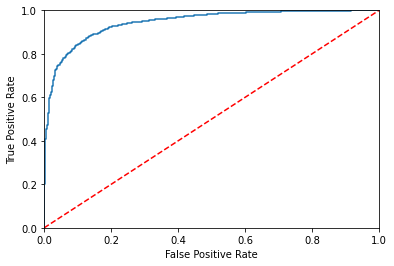

In [176]:
test.ROC_curve()

In [71]:
test.SaveModel()

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(200, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14e304049940>, 22980494195808), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(112,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14e6908894f0>, 22980494196528), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(112, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14e6907caf40>, 22965252907376), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(112,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x14e303e46e50>, 22979970414512), {}).
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(112, 1), dtype=

INFO:tensorflow:Assets written to: savedmodel/assets


INFO:tensorflow:Assets written to: savedmodel/assets


In [7]:
datatest = PulseProfileANN('TrainSetBalanced.npy','TestSetBalanced.npy')

In [9]:
datatest.LoadData('test')

In [10]:
datatest.BalanceData('test')

poscount is  1000.0
negcount is  1000.0
2000.0
test


In [411]:
#testing shuffle on smaller subset

fulldatadict = test.testdatadict
smalldatadict = {}
   
for key in fulldatadict.keys():
    i = 1
    smalldatadict[key] = []
    while i < 5:
        item = fulldatadict[key][i]
        smalldatadict[key].append(item)
        item = fulldatadict[key][-i]
        smalldatadict[key].append(item)
        i = i + 1

In [ ]:
    def SplitData(self, train = 70, validate = 15, test = 15):
        #Method to split unshuffled data with positive labels at the front of the set
        #15 validation, 15 test, 70 training default
        
        totaldatadict = self.datadict
        pospercent = self.pos
        posrange = pospercent*len(totaldatadict['Subband'])
        negrange = negpercent*len(totaldatadict['Subband'])
        traindict = {}
        validatedict = {}
        testdict = {}
        for key in totaldatadict.keys():
                print(key)
                for i in range(pospoints): 
                    if i < (train/100)*pospoints:
                        traindict[key][i] = totaldatadict[key][i]
                    elif ((train/100)*pospoints) <= i < (((train/100)*pospoints)+((validate/100)*pospoints)):
                        validatedict[key][i] = totaldatadict[key][i]
                    elif (((train/100)*pospoints)+((validate/100)*pospoints)) <= i :
                        testdict[key][i] = totaldatadict[key][i]
                for i in range(negrange)
                    if 
   # def AddData(self, newdatafile)
        